# GAN for function generation
The implementation of the Generative Adversarial Network (GAN) as a mathematical one-one function generator.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', size=15)

## Training data
Manual generate the training data as discrete series of a function y(x). Preprocess the data using a standard scaler.

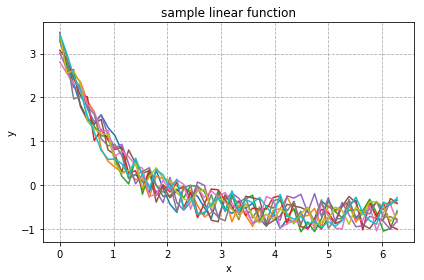

In [2]:
N = 5000
n_noise = 100

# generate training data
x = np.linspace(0, 2*np.pi, 50).reshape(1, -1)
err = np.random.uniform(-0.1, 0.1, size=(N, 50))
X_train = np.exp(-x) + err
X_train = X_train.reshape(N, -1, 1)

# preprocess
mean = np.mean(X_train, axis=1, keepdims=True)
stdv = np.std(X_train, axis=1, keepdims=True)
X_train = (X_train-mean)/stdv

# plot a sample
fig, ax = plt.subplots(1)

for i in range(10):
    ax.plot(x.ravel(), X_train[i])
ax.set(xlabel='x', ylabel='y', title='sample linear function')
ax.grid(ls='--')

fig.tight_layout()

Preprocess the data by normalization 

## Create GAN
Create a discriminator and generator network.

In [3]:
from keras.layers import Input, Dense, Activation, Dropout, Reshape, LeakyReLU
from keras.layers import BatchNormalization, Flatten, Conv1D, LSTM
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.


The discrimator predicts if a given example is generated or real.

In [4]:
def discriminator(input_shape, dropout=0.1):
    
    model = Sequential()

    model.add(Conv1D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(LeakyReLU())

    model.add(Conv1D(128, 5, strides=2, input_shape=input_shape, padding='same'))
    model.add(BatchNormalization(axis=-1))
    model.add(LeakyReLU())
    
    model.add(Flatten())    
    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(rate=dropout))
    model.add(Dense(128))
    model.add(LeakyReLU())
    model.add(Dropout(rate=dropout))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [5]:
discriminator_net = discriminator(input_shape = X_train.shape[1:])
discriminator_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 25, 64)            384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 64)            256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 128)           41088     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 128)           512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 13, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1664)              0         
__________

The generator generates fake examples from a random noise vector.

In [6]:
def generator(input_dim, output_dim, dropout=0.1):
    
    model =  Sequential()
    model.add(Dense(output_dim*128, input_dim=input_dim))
    model.add(LeakyReLU())
    model.add(BatchNormalization(axis=-1))
    model.add(Reshape((output_dim, 128)))
    model.add(Dropout(dropout))

    model.add(Conv1D(64, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv1D(32, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv1D(1, 5, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    return model

In [7]:
generator_net = generator(input_dim=n_noise, output_dim=X_train.shape[1])
generator_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6400)              646400    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6400)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 6400)              25600     
_________________________________________________________________
reshape_1 (Reshape)          (None, 50, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 50, 64)            41024     
_________________________________________________________________
batch_normalization_4 (Batch (None, 50, 64)            256       
__________

Combine the generator and discriminator to create GAN

In [8]:
discriminator_model = Sequential()
discriminator_model.add(discriminator_net)
discriminator_model.compile(loss='binary_crossentropy', 
                            optimizer=RMSprop(lr=0.001),
                            metrics=['accuracy'])
discriminator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1)                 272001    
Total params: 272,001
Trainable params: 271,617
Non-trainable params: 384
_________________________________________________________________


In [9]:
adversarial_model = Sequential()
adversarial_model.add(generator_net)
for layer in discriminator_net.layers:
    layer.trainable = False
adversarial_model.add(discriminator_net)
adversarial_model.compile(loss='binary_crossentropy',
                          optimizer=Adam(lr=0.001),
                          metrics=['accuracy'])
adversarial_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 50, 1)             723845    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 272001    
Total params: 995,846
Trainable params: 710,851
Non-trainable params: 284,995
_________________________________________________________________


## Train GAN on function

The training process has two stops: training the discriminator and training the generator:

1. Training the discriminator: training the discriminator to distinguish between real (label=0) and generated (label=1) series. 

2. Training the generator: training the advesarial model while freezing the discriminator. Here we only train on generated series labeled as real in hope that the generator will learn the mapping from the latent space to the distribution of the training data.

In [13]:
batch_size = 32

for i in range(2000):
    
    # randomly sample from training set
    real = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
    
    # generate function
    noise = np.random.uniform(-1., 1., size=(batch_size, n_noise))
    fake = generator_net.predict(noise)
    
    # create batch
    x_train = np.concatenate((real, fake), axis=0)
    y_train = np.zeros((2*batch_size, 1))  # real
    y_train[batch_size:] = 1

    # train discriminator model
    discriminator_model.train_on_batch(x_train, y_train)
    
    # train adversarial model
    y_train = np.zeros([batch_size, 1])  # label generated series as real
    noise = np.random.uniform(-1.0, 1.0, size=(batch_size, n_noise))
    adversarial_model.train_on_batch(noise, y_train)    

/home/chris/anaconda3/envs/ligo/lib/python3.6/site-packages/keras/engine/training.py:478: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


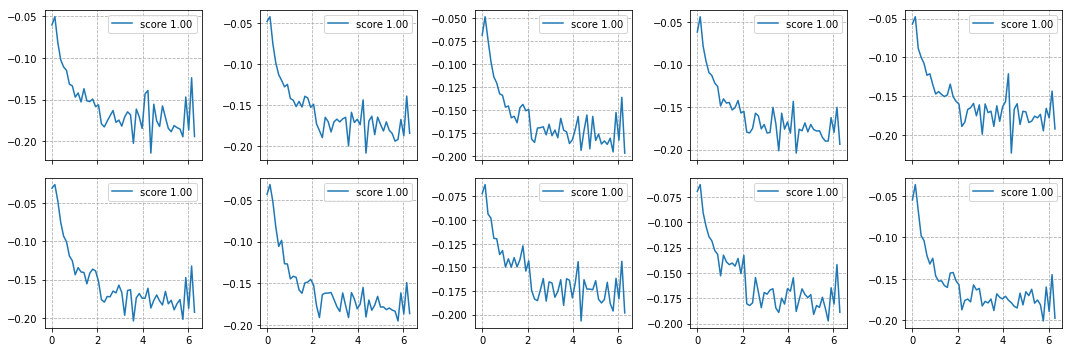

In [14]:
# pred = generator_net.predict(X_test)
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharex=True)

X_test = np.random.uniform(-1, 1, size=(10, n_noise))
pred = generator_net.predict(X_test)
score = discriminator_model.predict(pred)
for i in range(10):
    ax = axes.flatten()[i]
    ax.plot(x.ravel(), pred[i], label='score %.2f' % score[i])
    ax.grid(ls='--')
    ax.legend()
    
fig.tight_layout()

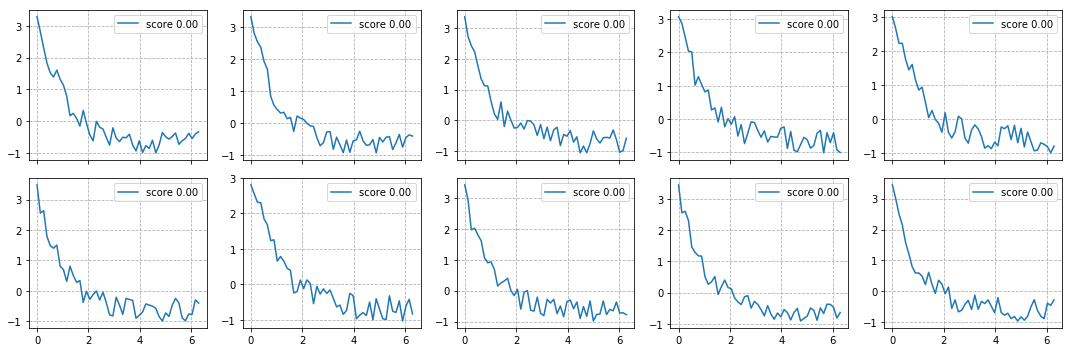

In [12]:
# pred = generator_net.predict(X_test)
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharex=True)

score = discriminator_model.predict(X_train[:10])
for i in range(10):
    ax = axes.flatten()[i]
    ax.plot(x.ravel(), X_train[i], label='score %.2f' % score[i])
    ax.grid(ls='--')
    ax.legend()
    
fig.tight_layout()